#LSTM and ARIMA with Bollinger Bands technical indicator


**Students:** Gabriel Sposito and Thomas Frentzel

**LSTM**


In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=883a3c13ee8dfbcf1fa2a91a19ca4c7cb55a9f58cac147e3eca7678dccd7e759
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator

In [3]:
base = pd.read_csv('AMD 5Y.csv')
base.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$172.80,34730150,$171.75,$173.60,$170.00
1,10/07/2024,$170.97,38379930,$171.08,$172.41,$168.21
2,10/04/2024,$170.90,44640300,$166.533,$171.21,$164.42
3,10/03/2024,$162.85,29598790,$159.71,$166.7894,$159.40
4,10/02/2024,$159.78,24630430,$159.31,$163.10,$158.6689


In [4]:
#Removing nule results
base.dropna()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$172.80,34730150,$171.75,$173.60,$170.00
1,10/07/2024,$170.97,38379930,$171.08,$172.41,$168.21
2,10/04/2024,$170.90,44640300,$166.533,$171.21,$164.42
3,10/03/2024,$162.85,29598790,$159.71,$166.7894,$159.40
4,10/02/2024,$159.78,24630430,$159.31,$163.10,$158.6689
...,...,...,...,...,...,...
1253,10/15/2019,$30.72,42142390,$30.70,$30.92,$30.17
1254,10/14/2019,$30.53,44818230,$29.71,$30.61,$29.38
1255,10/11/2019,$29.75,66632450,$28.83,$30.20,$28.81
1256,10/10/2019,$28.38,41172000,$28.52,$28.89,$28.00


In [5]:
# Removing $
base['Close/Last'] = base['Close/Last'].str.replace('$', '')
base['Open'] = base['Open'].str.replace('$', '')
base['High'] = base['High'].str.replace('$', '')
base['Low'] = base['Low'].str.replace('$', '')

# Converting str to float
base['Close/Last'] = base['Close/Last'].astype(float)
base['Open'] = base['Open'].astype(float)
base['High'] = base['High'].astype(float)
base['Low'] = base['Low'].astype(float)

In [6]:
cci = CCIIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'], window=20, constant=0.015)
base['CCI'] = cci.cci()

sma_tp = base['High'] + base['Low'] + base['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base['Close/Last'], window=14)
base['RSI'] = rsi.rsi()

macd = MACD(close=base['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base['MACD'] = macd.macd()
base['MACD_Signal'] = macd.macd_signal()
base['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'])
base['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base['Close/Last'], window=20, window_dev=2)
base['Bollinger_High'] = bollinger.bollinger_hband()
base['Bollinger_Low'] = bollinger.bollinger_lband()
base['Bollinger_Middle'] = bollinger.bollinger_mavg()
base['Bollinger_Width'] = bollinger.bollinger_wband()

base.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,157.81,42791250,156.12,158.6500,155.07,128.490106,56.724050,-1.735664,-4.266283,2.530619,146.212562,159.538951,134.672049,147.1055,16.904128
34,08/20/2024,156.40,76851160,156.49,162.0400,154.51,120.837780,54.942210,-1.096467,-3.632320,2.535853,148.392952,160.585017,134.436983,147.5110,17.726158
35,08/19/2024,155.28,60766850,148.43,155.3650,147.72,60.194674,53.504486,-0.672520,-3.040360,2.367840,162.040000,161.173218,134.294782,147.7340,18.193805
36,08/16/2024,148.56,31123930,145.70,149.3693,145.20,2.305252,45.766121,-0.868773,-2.606043,1.737270,162.040000,160.856405,134.259595,147.5580,18.024648
37,08/15/2024,147.36,43582390,143.00,147.9600,141.81,-19.231609,44.527651,-1.108358,-2.306506,1.198148,161.366400,160.428964,134.192036,147.3105,17.810630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,30.72,42142390,30.70,30.9200,30.17,-99.383285,24.075332,-2.154763,-2.139259,-0.015504,31.550800,37.639676,29.249324,33.4445,25.087388
1254,10/14/2019,30.53,44818230,29.71,30.6100,29.38,-105.536352,23.449722,-2.121456,-2.135699,0.014243,31.410000,37.317478,28.993522,33.1555,25.105806
1255,10/11/2019,29.75,66632450,28.83,30.2000,28.81,-117.461809,21.033342,-2.133407,-2.135240,0.001833,31.004000,36.981669,28.675331,32.8285,25.302215
1256,10/10/2019,28.38,41172000,28.52,28.8900,28.00,-148.813340,17.602422,-2.227746,-2.153741,-0.074004,30.610000,36.699642,28.167358,32.4335,26.307012


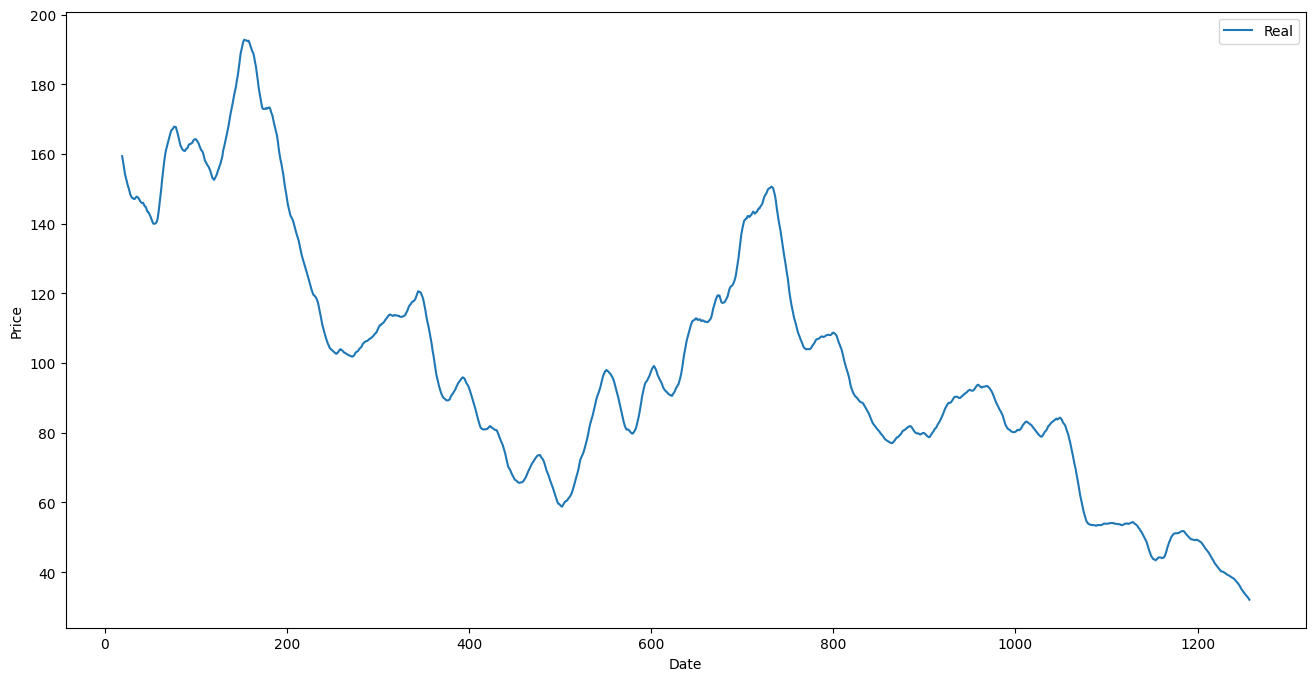

In [7]:
plt.figure(figsize=(16,8))
plt.plot(base['Bollinger_Middle'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

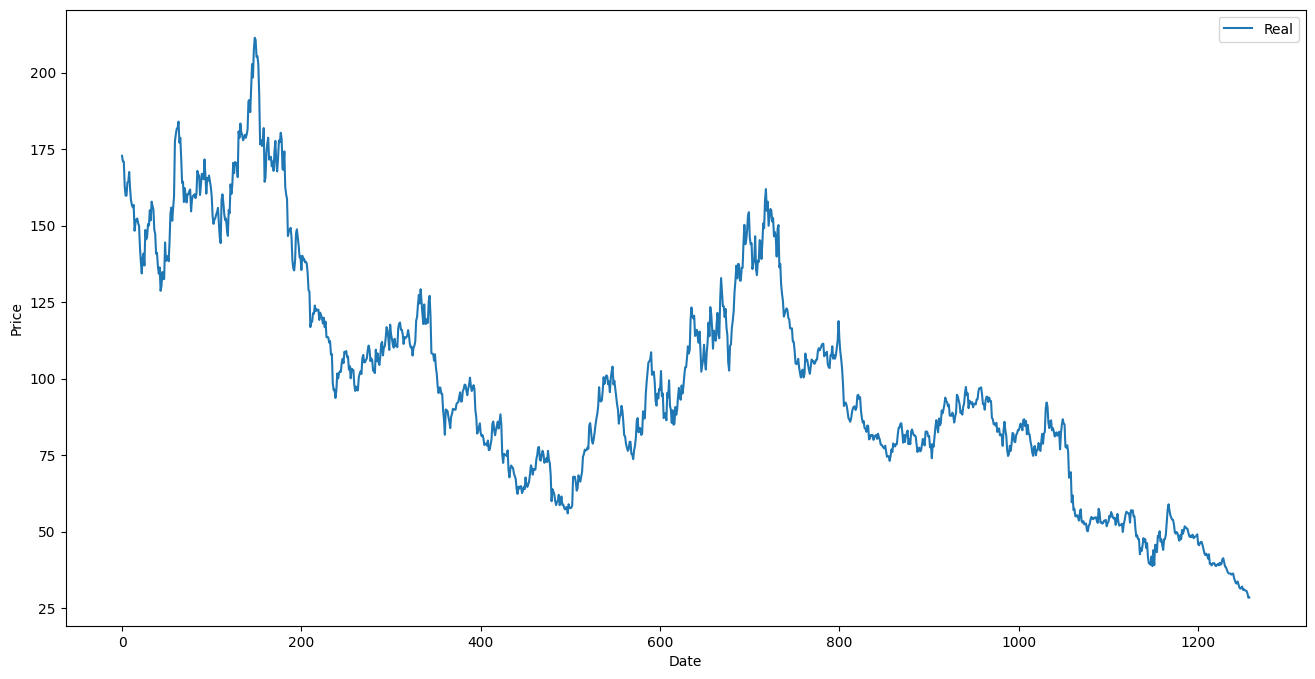

In [8]:
plt.figure(figsize=(16,8))
plt.plot(base['Close/Last'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [9]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base = base.replace([np.inf, -np.inf], np.nan)
base = base.dropna()

In [10]:
# Normalizing the data of real values
scaler_real_value = MinMaxScaler(feature_range=(0, 1))
scaled_data_real_value = scaler_real_value.fit_transform(np.array(base['Close/Last']).reshape(-1, 1))

In [11]:
window_size_real_value = 10
forecasters_real_value = []
real_value_of_prices = []
for i in range(window_size_real_value, len(base)):
    forecasters_real_value.append(scaled_data_real_value[i - window_size_real_value:i, 0])
    real_value_of_prices.append(scaled_data_real_value[i, 0])

forecasters_real_value, real_value_of_prices = np.array(forecasters_real_value), np.array(real_value_of_prices)
forecasters_real_value = np.reshape(forecasters_real_value, (forecasters_real_value.shape[0], forecasters_real_value.shape[1], 1))

In [12]:
#dividindo a coluna close/last em 70% treino e 30% teste com trai_test_split
Xtrain_real_lstm, Xtest_real_lstm, ytrain_real_lstm, ytest_real_lstm = train_test_split(forecasters_real_value, real_value_of_prices,
                                                                                        test_size = 0.3, shuffle = False)

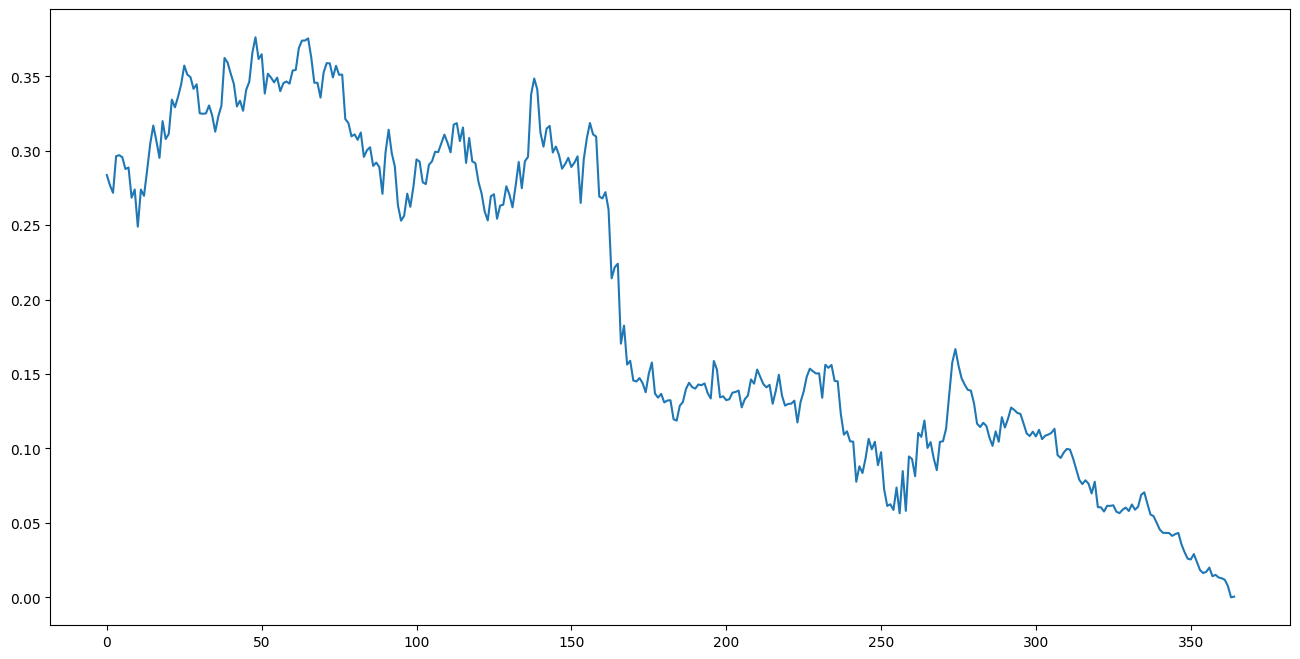

In [13]:
#plotando grafico dos valores de teste
plt.figure(figsize=(16,8))
plt.plot(ytest_real_lstm)
plt.show()

In [14]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(base['Bollinger_Middle']).reshape(-1, 1))

In [15]:
window_size = 10
forecasters = []
real_value = []
for i in range(window_size, len(base)):
    forecasters.append(scaled_data[i - window_size:i, 0])
    real_value.append(scaled_data[i, 0])

forecasters, real_value = np.array(forecasters), np.array(real_value)
forecasters = np.reshape(forecasters, (forecasters.shape[0], forecasters.shape[1], 1))

In [16]:
# Separating data between training and testing
X_train, X_test, y_train, y_test = train_test_split(forecasters, real_value, test_size=0.3, shuffle=False)

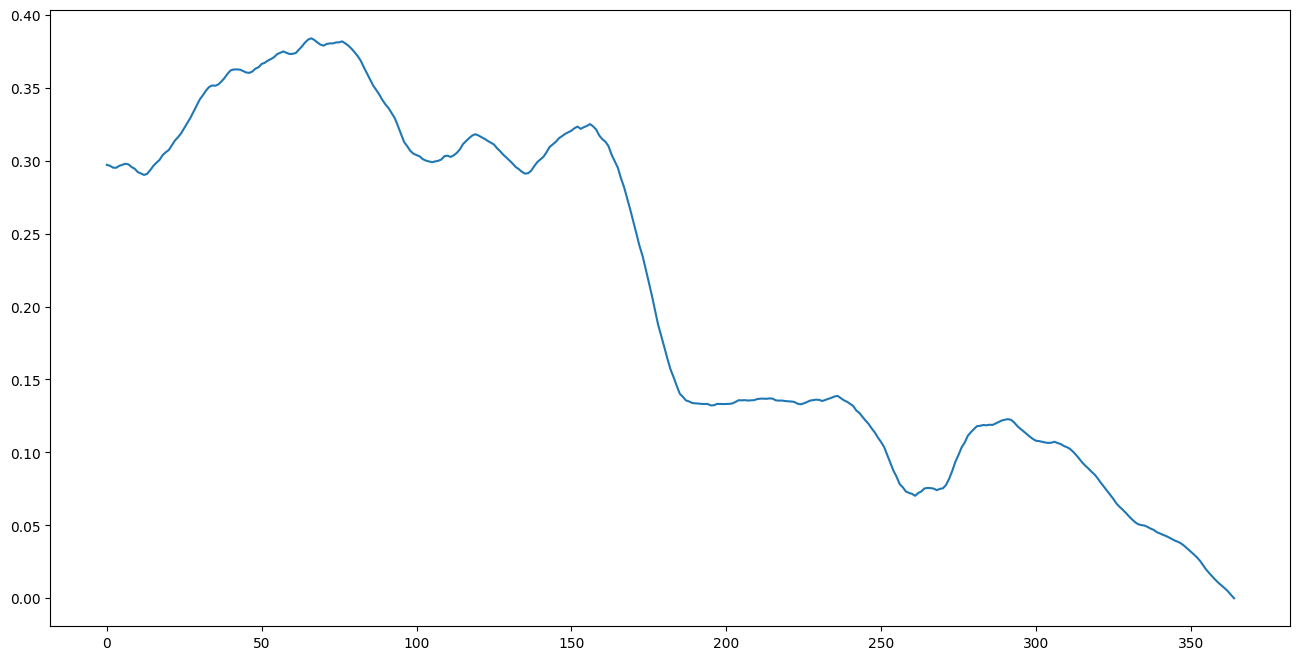

In [17]:
# Showing test set in graph
plt.figure(figsize=(16, 8))
plt.plot(y_test)
plt.show()

In [18]:
# LSTM model

lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(forecasters.shape[1], 1)))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.3))
lstm.add(Dense(units=1))
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.1216 - mean_absolute_error: 0.2848 - val_loss: 0.0073 - val_mean_absolute_error: 0.0680
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0134 - mean_absolute_error: 0.0884 - val_loss: 0.0059 - val_mean_absolute_error: 0.0673
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0056 - mean_absolute_error: 0.0582 - val_loss: 0.0016 - val_mean_absolute_error: 0.0323
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0058 - mean_absolute_error: 0.0585 - val_loss: 0.0010 - val_mean_absolute_error: 0.0257
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0057 - mean_absolute_error: 0.0561 - val_loss: 9.9007e-04 - val_mean_absolute_error: 0.0267
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0043 - mean_absolute_error: 0.0501 - val_loss: 6.7097e-04 - val_mean_absolute_error: 0.0219
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0051 - mean_absolute_error: 0.

In [20]:
test_predictions = lstm.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [21]:
# Transforming test values ​​back to original values
y_orig_test = scaler.inverse_transform(y_test.reshape(-1, 1))

#escalonando valores de teste
ytest_real_lstm = scaler_real_value.inverse_transform(ytest_real_lstm.reshape(-1, 1))

In [22]:
test_predictions = test_predictions.ravel()  # Converts to 1D
y_orig_test = y_orig_test.ravel()
ytest_real_lstm = ytest_real_lstm.ravel()

In [23]:
print(test_predictions.shape)
print(y_orig_test.shape)

(365,)
(365,)


In [24]:
test_size_L = len(y_test)

close_test_L = base['Close/Last'].tail(test_size_L)

In [25]:
# Inverse Bollinger Bands formula
def Bandas_Bollinger_Middle_inverse(bollinger_values_L, close_values_L, window=20):
    original_prices = []

    for i in range(len(bollinger_values_L)):
        if i < window:
            # For the first values, where there is not enough data to calculate the SMA, we keep the original closing value
            original_prices.append(close_values_L[i])
            continue

       # Calculates the simple moving average (SMA) of the last 'window' periods
        middle_ma = np.mean(close_values_L[i-window:i])

        # Using the ratio between the predicted middle band value and the actual SMA value assuming that the middle band value (bollinger_values_L[i]) represents an estimate of the SMA
        estimated_price = bollinger_values_L[i] + (close_values_L[i] - middle_ma)

        original_prices.append(estimated_price)

    return np.array(original_prices)

# Making sure the data is in array format
close_test_L = close_test_L.values if isinstance(close_test_L, pd.Series) else close_test_L

In [26]:
# Inverting the values ​​test_predictions and y_orig_teste by the inverse Parabolic SAR formula
test_predictions_inverted = Bandas_Bollinger_Middle_inverse(test_predictions, close_test_L)
y_orig_test_inverted = Bandas_Bollinger_Middle_inverse(y_orig_test, close_test_L)

min_length = min(len(ytest_real_lstm), len(test_predictions_inverted))
ytest_real_lstm = ytest_real_lstm[:min_length]
test_predictions_inverted = test_predictions_inverted[:min_length]

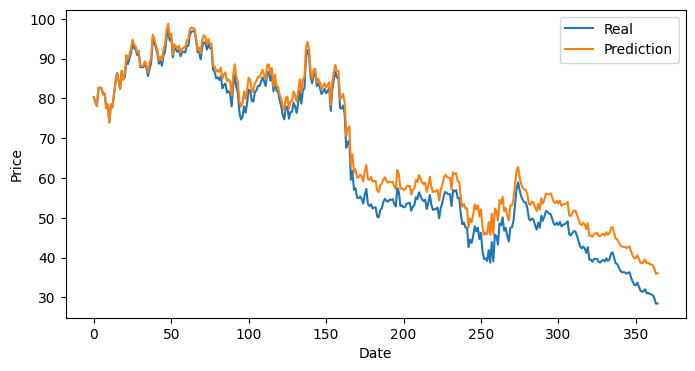

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(ytest_real_lstm)), ytest_real_lstm, label='Real')
plt.plot(range(len(test_predictions_inverted)), test_predictions_inverted, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
# R2 Score
r2 = r2_score(ytest_real_lstm, test_predictions_inverted)
print(f'R2 Score: {r2}')

# RMSE
rmse = np.sqrt(np.mean((ytest_real_lstm - test_predictions_inverted) ** 2))
print(f'RMSE: {rmse}')

R2 Score: 0.9554195400552503
RMSE: 4.236482152675979


**ARIMA**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator
from math import sqrt

In [31]:
base_A = pd.read_csv('AMD 5Y.csv')
base_A.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$172.80,34730150,$171.75,$173.60,$170.00
1,10/07/2024,$170.97,38379930,$171.08,$172.41,$168.21
2,10/04/2024,$170.90,44640300,$166.533,$171.21,$164.42
3,10/03/2024,$162.85,29598790,$159.71,$166.7894,$159.40
4,10/02/2024,$159.78,24630430,$159.31,$163.10,$158.6689


In [32]:
base_A.dtypes

,0
Date,object
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


In [33]:
# Removing $
base_A['Close/Last'] = base_A['Close/Last'].str.replace('$', '')
base_A['Open'] = base_A['Open'].str.replace('$', '')
base_A['High'] = base_A['High'].str.replace('$', '')
base_A['Low'] = base_A['Low'].str.replace('$', '')

# Converting str to float
base_A['Close/Last'] = base_A['Close/Last'].astype(float)
base_A['Open'] = base_A['Open'].astype(float)
base_A['High'] = base_A['High'].astype(float)
base_A['Low'] = base_A['Low'].astype(float)

In [34]:
cci = CCIIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'], window=20, constant=0.015)
base_A['CCI'] = cci.cci()

sma_tp = base_A['High'] + base_A['Low'] + base_A['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base_A['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base_A['Close/Last'], window=14)
base_A['RSI'] = rsi.rsi()

macd = MACD(close=base_A['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base_A['MACD'] = macd.macd()
base_A['MACD_Signal'] = macd.macd_signal()
base_A['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'])
base_A['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base_A['Close/Last'], window=20, window_dev=2)
base_A['Bollinger_High'] = bollinger.bollinger_hband()
base_A['Bollinger_Low'] = bollinger.bollinger_lband()
base_A['Bollinger_Middle'] = bollinger.bollinger_mavg()
base_A['Bollinger_Width'] = bollinger.bollinger_wband()

base_A.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,157.81,42791250,156.12,158.6500,155.07,128.490106,56.724050,-1.735664,-4.266283,2.530619,146.212562,159.538951,134.672049,147.1055,16.904128
34,08/20/2024,156.40,76851160,156.49,162.0400,154.51,120.837780,54.942210,-1.096467,-3.632320,2.535853,148.392952,160.585017,134.436983,147.5110,17.726158
35,08/19/2024,155.28,60766850,148.43,155.3650,147.72,60.194674,53.504486,-0.672520,-3.040360,2.367840,162.040000,161.173218,134.294782,147.7340,18.193805
36,08/16/2024,148.56,31123930,145.70,149.3693,145.20,2.305252,45.766121,-0.868773,-2.606043,1.737270,162.040000,160.856405,134.259595,147.5580,18.024648
37,08/15/2024,147.36,43582390,143.00,147.9600,141.81,-19.231609,44.527651,-1.108358,-2.306506,1.198148,161.366400,160.428964,134.192036,147.3105,17.810630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,30.72,42142390,30.70,30.9200,30.17,-99.383285,24.075332,-2.154763,-2.139259,-0.015504,31.550800,37.639676,29.249324,33.4445,25.087388
1254,10/14/2019,30.53,44818230,29.71,30.6100,29.38,-105.536352,23.449722,-2.121456,-2.135699,0.014243,31.410000,37.317478,28.993522,33.1555,25.105806
1255,10/11/2019,29.75,66632450,28.83,30.2000,28.81,-117.461809,21.033342,-2.133407,-2.135240,0.001833,31.004000,36.981669,28.675331,32.8285,25.302215
1256,10/10/2019,28.38,41172000,28.52,28.8900,28.00,-148.813340,17.602422,-2.227746,-2.153741,-0.074004,30.610000,36.699642,28.167358,32.4335,26.307012


In [35]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base_A = base_A.replace([np.inf, -np.inf], np.nan)
base_A = base_A.dropna()

In [36]:
base_A.head()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,157.81,42791250,156.12,158.6500,155.07,128.490106,56.724050,-1.735664,-4.266283,2.530619,146.212562,159.538951,134.672049,147.1055,16.904128
34,08/20/2024,156.40,76851160,156.49,162.0400,154.51,120.837780,54.942210,-1.096467,-3.632320,2.535853,148.392952,160.585017,134.436983,147.5110,17.726158
35,08/19/2024,155.28,60766850,148.43,155.3650,147.72,60.194674,53.504486,-0.672520,-3.040360,2.367840,162.040000,161.173218,134.294782,147.7340,18.193805
36,08/16/2024,148.56,31123930,145.70,149.3693,145.20,2.305252,45.766121,-0.868773,-2.606043,1.737270,162.040000,160.856405,134.259595,147.5580,18.024648
37,08/15/2024,147.36,43582390,143.00,147.9600,141.81,-19.231609,44.527651,-1.108358,-2.306506,1.198148,161.366400,160.428964,134.192036,147.3105,17.810630


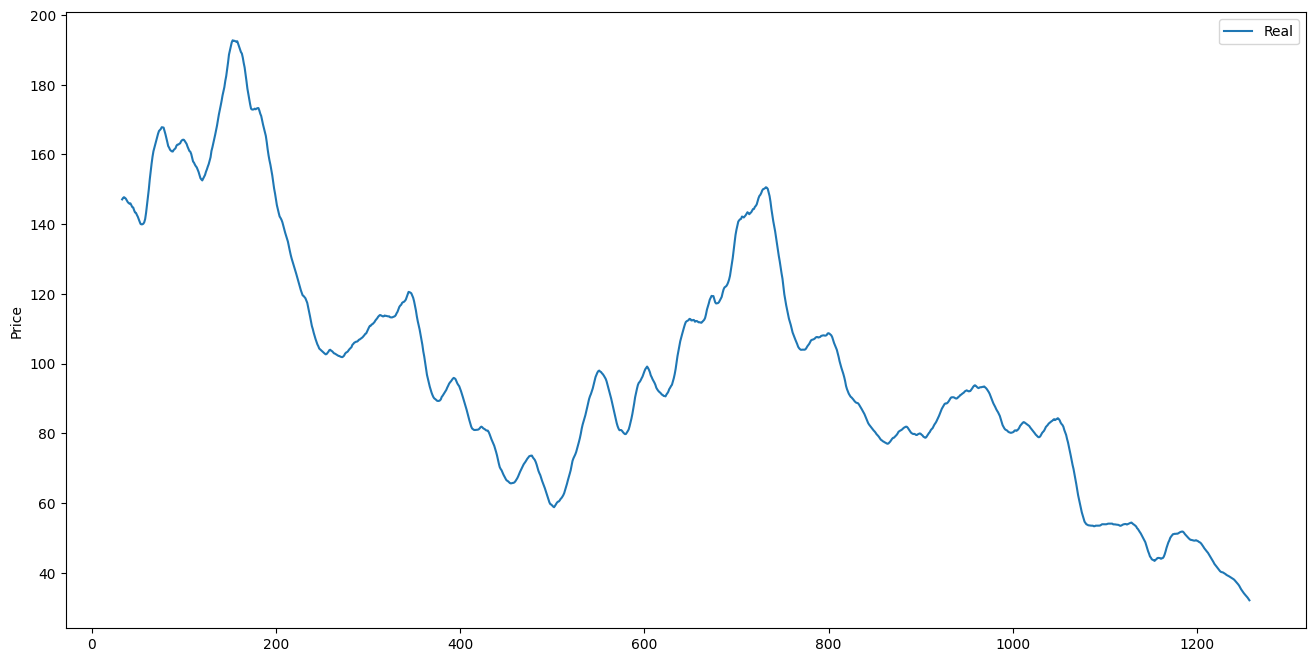

In [37]:
# Plotting Bollinger Bands
plt.figure(figsize=(16,8))
plt.plot(base_A['Bollinger_Middle'], label='Real')
plt.ylabel('Price')
plt.legend()

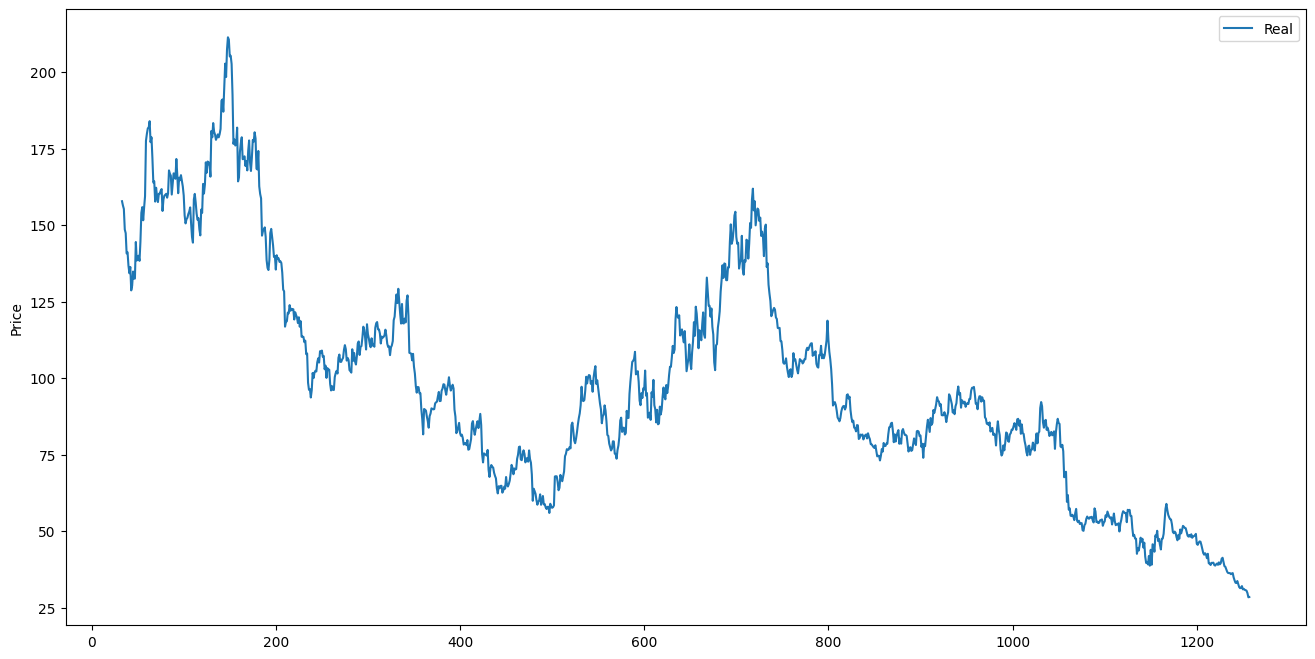

In [38]:
plt.figure(figsize=(16,8))
plt.plot(base_A['Close/Last'], label='Real')
plt.ylabel('Price')
plt.legend()

In [39]:
X_R = base_A['Close/Last'].values
size_R = int(len(X_R) * 0.70)
train_R, test_R = X_R[0:size_R], X_R[size_R:len(X_R)]
history_R = [x_r for x_r in train_R]
forecasts_R = list()

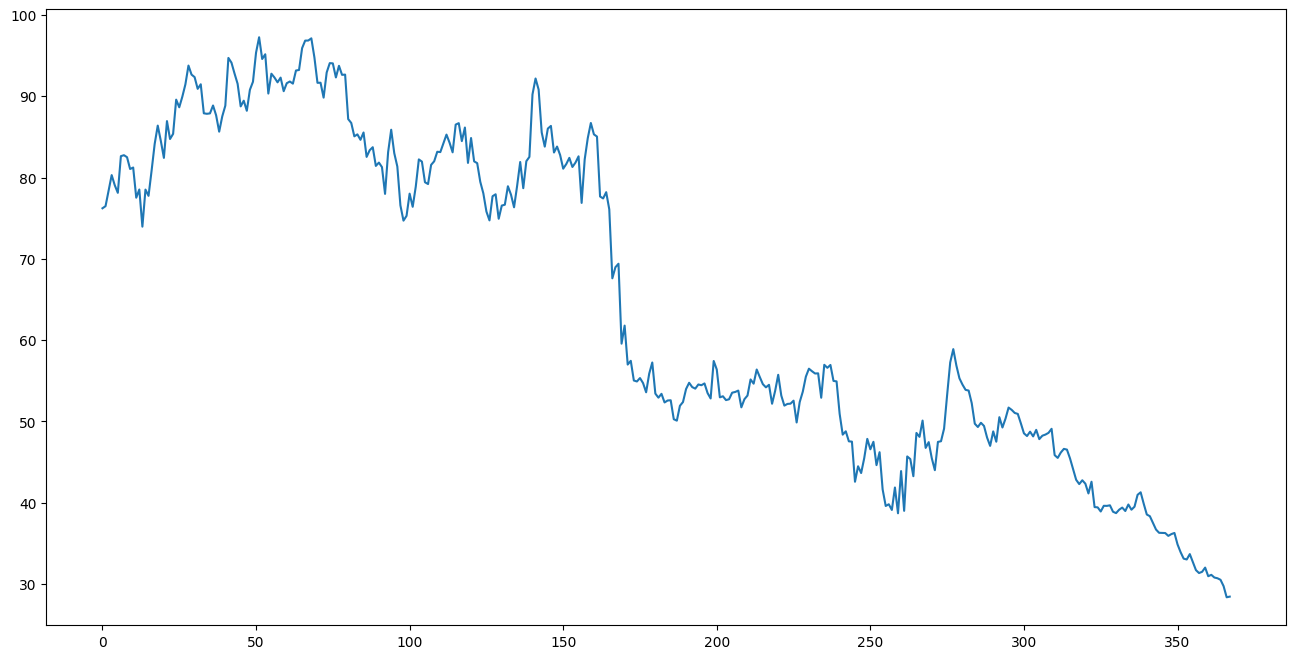

In [40]:
#Test Grafic
plt.figure(figsize=(16, 8))
plt.plot(test_R)
plt.show()

In [41]:
# Addfuller for Bollinger Bands Middle
result = adfuller(base_A['Bollinger_Middle'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.4410850318870292
p-value: 0.562428766218112


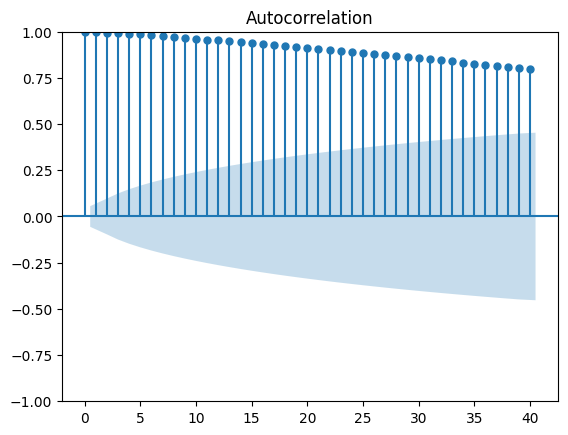

In [42]:
plot_acf(base_A['Bollinger_Middle'], lags=40)
plt.show()

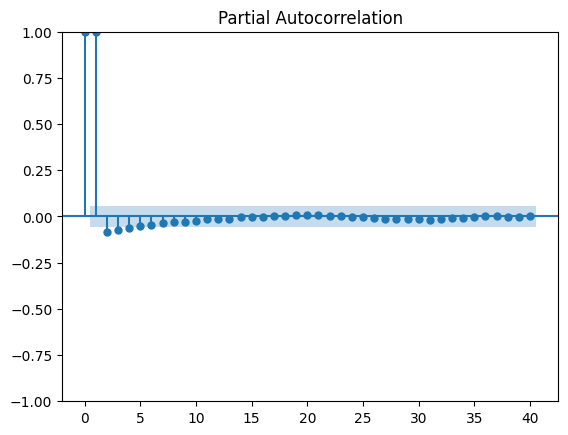

In [43]:
plot_pacf(base_A['Bollinger_Middle'], lags=40)
plt.show()

In [44]:
X = base_A['Bollinger_Middle'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
forecasts = list()

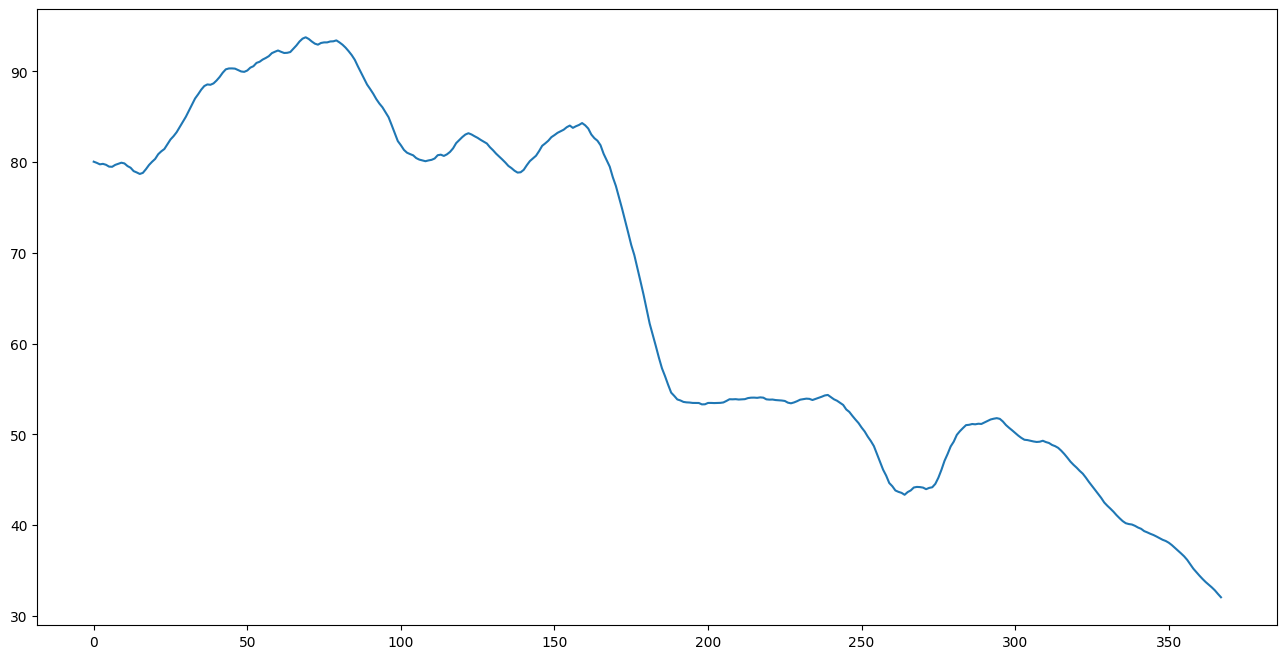

In [45]:
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.show()

In [46]:
# ARIMA
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    forecasts.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'Expected={yhat}, Observed={obs}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Expected=79.95235579308869, Observed=80.05350000000001
Expected=79.79536056800642, Observed=79.9245
Expected=79.76028103058924, Observed=79.763
Expected=79.64982845059473, Observed=79.8145
Expected=79.83425920973038, Observed=79.712
Expected=79.63591574364926, Observed=79.51050000000001
Expected=79.29334497647757, Observed=79.4915
Expected=79.50862286738924, Observed=79.70150000000001
Expected=79.87728016149329, Observed=79.81700000000001
Expected=79.94497028772263, Observed=79.94050000000001
Expected=80.03965527885094, Observed=79.864


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=79.79916400401613, Observed=79.5725
Expected=79.27743314664224, Observed=79.389
Expected=79.2390072015257, Observed=79.01500000000001
Expected=78.62671375754412, Observed=78.8695
Expected=78.7764268584681, Observed=78.7025
Expected=78.49843233444616, Observed=78.8205
Expected=78.99189322920031, Observed=79.227
Expected=79.56747157560152, Observed=79.6895
Expected=80.17553909353737, Observed=80.0445
Expected=80.32863194618753, Observed=80.3545
Expected=80.6983287675743, Observed=80.8775
Expected=81.3344141146295, Observed=81.19550000000001
Expected=81.52553937876264, Observed=81.449
Expected=81.65773833012629, Observed=81.975
Expected=82.51886569030104, Observed=82.501
Expected=82.95498097500695, Observed=82.8665
Expected=83.24958200724234, Observed=83.30199999999999
Expected=83.68213846579314, Observed=83.8655
Expected=84.43890795823152, Observed=84.446
Expected=84.95857248309052, Observed=85.002
Expected=85.5657762621559, Observed=85.6715
Expected=86.27593391930195, Observed=

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=87.65007292819115, Observed=87.4815
Expected=87.93828333821985, Observed=87.9885
Expected=88.4567011903286, Observed=88.3885
Expected=88.77506335581963, Observed=88.565
Expected=88.71390683882152, Observed=88.5275
Expected=88.4995009020989, Observed=88.678
Expected=88.82267092276038, Observed=88.999
Expected=89.31003338973832, Observed=89.3875
Expected=89.75270135223718, Observed=89.857
Expected=90.30954230247886, Observed=90.228
Expected=90.56758892644295, Observed=90.3255
Expected=90.41625388902806, Observed=90.33099999999999
Expected=90.33322453043216, Observed=90.3065
Expected=90.28471323681626, Observed=90.14399999999999
Expected=89.98146183290707, Observed=89.99499999999999
Expected=89.86284472599075, Observed=89.951
Expected=89.90555664745307, Observed=90.10125
Expected=90.25730127550035, Observed=90.41825
Expected=90.71377828362249, Observed=90.57375
Expected=90.71794805880585, Observed=90.93674999999999
Expected=91.29461115732921, Observed=91.06125
Expected=91.1536782

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=92.8790020107521, Observed=93.13399999999999
Expected=93.28796061993683, Observed=93.19749999999999
Expected=93.27462899672031, Observed=93.19800000000001
Expected=93.17843036883498, Observed=93.2995
Expected=93.42063238465134, Observed=93.31649999999999
Expected=93.30362871543457, Observed=93.41850000000001
Expected=93.54811198245751, Observed=93.19800000000001
Expected=92.94085192882764, Observed=92.943
Expected=92.7477909376346, Observed=92.619
Expected=92.2628546011854, Observed=92.2265


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=91.90026934821249, Observed=91.797
Expected=91.34297277716809, Observed=91.278


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=90.82857473456308, Observed=90.563


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=89.83173810389388, Observed=89.8885


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=89.30218917391831, Observed=89.219


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=88.53170247937074, Observed=88.5515


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=87.97150002248291, Observed=88.061


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=87.55202174897326, Observed=87.542
Expected=87.09227394394652, Observed=86.95


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=86.34297609003603, Observed=86.46000000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=86.04606480419308, Observed=86.0505


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=85.61575829050477, Observed=85.4985


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=85.01440652760557, Observed=84.9505


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=84.39208879271436, Observed=84.0925


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=83.30205312454355, Observed=83.196


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=82.3194580315954, Observed=82.3275


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=81.53020310692487, Observed=81.869


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=81.42820893085381, Observed=81.35350000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=80.8679884611315, Observed=81.044
Expected=80.75767601806844, Observed=80.89


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=80.7446811060968, Observed=80.756
Expected=80.62915785899887, Observed=80.45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=80.15097209585149, Observed=80.28299999999999


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=80.14060305475516, Observed=80.19300000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=80.09573083089249, Observed=80.10650000000001
Expected=80.03654178404436, Observed=80.1935


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=80.27253559222343, Observed=80.25800000000001
Expected=80.32105955195624, Observed=80.40450000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=80.54536418148507, Observed=80.769
Expected=81.12357398548886, Observed=80.8275
Expected=80.85848606916466, Observed=80.6885
Expected=80.57120864075686, Observed=80.864


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=81.03179868647636, Observed=81.131


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=81.38685971855124, Observed=81.526


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=81.90346851474669, Observed=82.0985


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=82.6460949637317, Observed=82.424
Expected=82.7142938202517, Observed=82.76599999999999
Expected=83.1090312696394, Observed=83.04549999999999
Expected=83.28832033523003, Observed=83.19


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=83.3420804505897, Observed=83.0525
Expected=82.89288266448412, Observed=82.85725
Expected=82.69860199500253, Observed=82.67724999999999
Expected=82.48122114302032, Observed=82.45375
Expected=82.26497643449893, Observed=82.26075
Expected=82.0563059744742, Observed=82.05775
Expected=81.88641734762663, Observed=81.64575
Expected=81.22389326661119, Observed=81.31675
Expected=81.04051128146519, Observed=80.93924999999999
Expected=80.54378414227473, Observed=80.62174999999999
Expected=80.36150710612816, Observed=80.30225
Expected=79.95898562522481, Observed=79.96425
Expected=79.68342196117393, Observed=79.58775
Expected=79.18980651629897, Observed=79.34875000000001
Expected=79.17004315603039, Observed=79.05924999999999
Expected=78.73497222436066, Observed=78.85225
Expected=78.70982557419234, Observed=78.88925
Expected=78.88265766296615, Observed=79.15725
Expected=79.46385531595557, Observed=79.66675000000001
Expected=80.1087496578749, Observed=80.11925000000001
Expected=80.585812010

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=82.39187600124542, Observed=82.64399999999999


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=82.30676132715533, Observed=82.364


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=82.05778402245951, Observed=81.86749999999999
Expected=81.42781040069562, Observed=80.93050000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=79.99202905937177, Observed=80.225


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=79.61905695247884, Observed=79.5045


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=78.7603455519351, Observed=78.34450000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=77.28659909823936, Observed=77.37950000000001
Expected=76.43344429406824, Observed=76.1465


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=74.99656811278207, Observed=74.8985


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=73.69542706578684, Observed=73.5855


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=72.35715303440765, Observed=72.23949999999999
Expected=70.94508851522504, Observed=70.876
Expected=69.59923202269351, Observed=69.768


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=68.71297520966196, Observed=68.3355
Expected=66.96408164964039, Observed=66.88700000000001
Expected=65.51444695599605, Observed=65.41425000000001
Expected=64.0036767985676, Observed=63.82025
Expected=62.312388489356366, Observed=62.21475
Expected=60.68255651266959, Observed=61.001250000000006
Expected=59.87558546402178, Observed=59.746750000000006


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=58.52728699418705, Observed=58.46575
Expected=57.27608239812127, Observed=57.29175


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=56.15544244075186, Observed=56.42524999999999
Expected=55.63945222590319, Observed=55.48175
Expected=54.54578771449845, Observed=54.60825000000001
Expected=53.82260337616964, Observed=54.249249999999996
Expected=53.89066895949607, Observed=53.859249999999996


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.505642039840865, Observed=53.747249999999994


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.63858898011696, Observed=53.585750000000004
Expected=53.43039491906142, Observed=53.53575000000001
Expected=53.490353329702636, Observed=53.517250000000004
Expected=53.49851595829214, Observed=53.47324999999999
Expected=53.43216370515771, Observed=53.47125
Expected=53.4687549633177, Observed=53.466750000000005
Expected=53.46258618498527, Observed=53.31425
Expected=53.16175324438183, Observed=53.3235
Expected=53.33383010145785, Observed=53.471500000000006


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.60294394109796, Observed=53.4735
Expected=53.476979312983225, Observed=53.4585


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.44170383163626, Observed=53.473


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.4907303275833, Observed=53.48049999999999


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.483382474465245, Observed=53.527


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.57724418340774, Observed=53.69449999999999
Expected=53.85328541226588, Observed=53.87949999999999
Expected=54.05467165453545, Observed=53.86999999999999


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.850340428784094, Observed=53.8875
Expected=53.90496938784273, Observed=53.847500000000004
Expected=53.79478848165356, Observed=53.86800000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.90558007842582, Observed=53.888999999999996
Expected=53.89112887653302, Observed=54.0065


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=54.140241027329246, Observed=54.05250000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=54.07035012919623, Observed=54.059000000000005
Expected=54.06566740378944, Observed=54.035000000000004
Expected=54.01171523231413, Observed=54.0855


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=54.16197929455405, Observed=54.053


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.98979261260443, Observed=53.86900000000001
Expected=53.694271729022276, Observed=53.8365
Expected=53.788199447479315, Observed=53.847500000000004


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.87764087565886, Observed=53.79


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.712687978832115, Observed=53.76649999999999
Expected=53.74450116098446, Observed=53.7395
Expected=53.68945649797872, Observed=53.6905


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.667708471248766, Observed=53.503


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.295195421325246, Observed=53.432500000000005


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.40158306866633, Observed=53.528499999999994


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.592259413526136, Observed=53.666999999999994


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.8278485038947, Observed=53.831999999999994


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.960345245727225, Observed=53.88250000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.95439312944066, Observed=53.94500000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.98275528480972, Observed=53.9215


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.916745079244286, Observed=53.794000000000004


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.6506405524303, Observed=53.913


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=54.0611332563735, Observed=54.032999999999994


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=54.11160095370895, Observed=54.154999999999994


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=54.30540178965895, Observed=54.295500000000004


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=54.3949680507778, Observed=54.354000000000006


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=54.438918728413846, Observed=54.11400000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.84212758227694, Observed=53.8735


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=53.68942264603356, Observed=53.7155
Expected=53.56542806255876, Observed=53.4855
Expected=53.267096990782484, Observed=53.251999999999995


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=52.99369786981264, Observed=52.75350000000001


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=52.303949996502105, Observed=52.484


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=52.21678864099126, Observed=52.0475
Expected=51.63111581440735, Observed=51.6385


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=51.24846350507719, Observed=51.25599999999999


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=50.89647212408652, Observed=50.7605


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=50.281722292499076, Observed=50.326499999999996


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=49.926803827127245, Observed=49.763000000000005


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=49.20984725463303, Observed=49.278


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=48.84040850725514, Observed=48.714


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=48.15256807567536, Observed=47.846


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=47.03333938305281, Observed=47.007
Expected=46.211844793560914, Observed=46.115500000000004
Expected=45.268707110913994, Observed=45.46
Expected=44.84007413837545, Observed=44.649
Expected=43.86620411795926, Observed=44.297000000000004


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=43.99822198328088, Observed=43.828500000000005


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=43.34232065990214, Observed=43.67399999999999
Expected=43.528387665556664, Observed=43.565
Expected=43.46099743349257, Observed=43.352500000000006
Expected=43.15135319931047, Observed=43.652499999999996
Expected=43.93798931816908, Observed=43.8335
Expected=44.00418227256586, Observed=44.156
Expected=44.46248362013726, Observed=44.2195
Expected=44.27916608035741, Observed=44.1995
Expected=44.18090365712729, Observed=44.14450000000001
Expected=44.09209199705457, Observed=43.970000000000006
Expected=43.80461599548875, Observed=44.113
Expected=44.249022369973204, Observed=44.1805
Expected=44.24409179650415, Observed=44.554500000000004
Expected=44.90932159757035, Observed=45.238


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=45.859975897449544, Observed=46.1105
Expected=46.9731871774264, Observed=47.0995
Expected=48.037528738002756, Observed=47.85


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=48.57874447717089, Observed=48.67999999999999
Expected=49.46762539340712, Observed=49.2115


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=49.71349247909175, Observed=49.9555
Expected=50.6613048081352, Observed=50.3605
Expected=50.744913592894136, Observed=50.704499999999996
Expected=51.03037960573645, Observed=51.027499999999996
Expected=51.333809966650215, Observed=51.06400000000001
Expected=51.09857472276541, Observed=51.1505
Expected=51.232495832312175, Observed=51.1175
Expected=51.086222922971395, Observed=51.181
Expected=51.241147559161796, Observed=51.158
Expected=51.13627905905429, Observed=51.323
Expected=51.4791325544332, Observed=51.498000000000005
Expected=51.66399453852679, Observed=51.65
Expected=51.79397791425005, Observed=51.734500000000004
Expected=51.81468468450311, Observed=51.79600000000001
Expected=51.85423289949033, Observed=51.71750000000001
Expected=51.643250008935894, Observed=51.4255
Expected=51.1487982315081, Observed=51.033
Expected=50.66101264946443, Observed=50.735
Expected=50.452535635718135, Observed=50.458000000000006
Expected=50.19549905196519, Observed=50.15875
Expected=49.87513

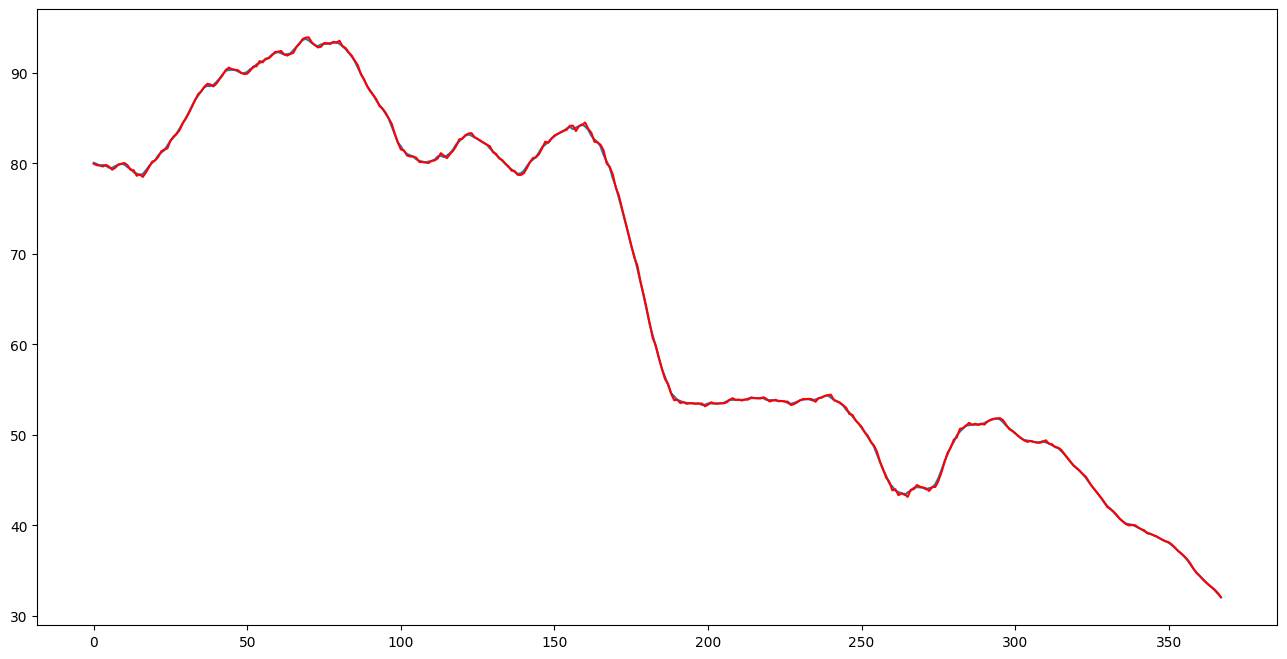

In [47]:
# Test and forecast set
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.plot(forecasts, color='red')
plt.show()

In [48]:
# Ensuring that data is one-dimensional
test = test.ravel()
forecasts = np.array(forecasts).ravel()

In [49]:
# Getting the high, low and close values ​​from the test set for Bollinger Bands
test_size_A = len(test)

close_test_A = base_A['Close/Last'].tail(test_size_A)

In [50]:
print(test.shape)
print(forecasts.shape)

(368,)
(368,)


In [51]:
# Inverse Bollinger Bands Formula
def Bandas_Bollinger_Middle_inverse(bollinger_values_A, close_values_A, window=20):
    original_prices = []

    for i in range(len(bollinger_values_A)):
        if i < window:
            # For the first values, where there is not enough data to calculate the SMA, we keep the original closing value
            original_prices.append(close_values_A[i])
            continue

        # Calculates the simple moving average (SMA) of the last 'window' periods
        middle_ma = np.mean(close_values_A[i-window:i])

        # Using the ratio between the predicted middle band value and the actual SMA value assuming that the middle band value (bollinger_values_L[i]) represents an estimate of the SMA
        estimated_price = bollinger_values_A[i] + (close_values_A[i] - middle_ma)

        original_prices.append(estimated_price)

    return np.array(original_prices)

# Making sure the data is in array format
close_test_A = close_test_A.values if isinstance(close_test_A, pd.Series) else close_test_A

In [52]:
test_inverted = Bandas_Bollinger_Middle_inverse(test, close_test_A)
forecasts_inverted = Bandas_Bollinger_Middle_inverse(forecasts, close_test_A)

min_length_R = min(len(test_R), len(forecasts_inverted))
test_R = test_R[:min_length_R]
forecasts_inverted = forecasts_inverted[:min_length_R]

In [53]:
# RMSE
rmse = sqrt(mean_squared_error(test_R, forecasts_inverted))
print(f'RMSE: {rmse}')

# R2 Score
r2 = r2_score(test_R, forecasts_inverted)
print(f'R2 Score: {r2}')

RMSE: 0.4208677730703181
R2 Score: 0.9995578525058746


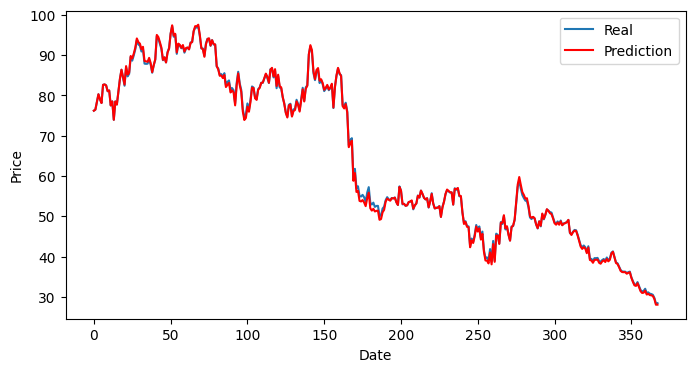

In [55]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(test_R)), test_R, label='Real')
plt.plot(range(len(forecasts_inverted)), forecasts_inverted, label='Prediction', color = 'red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()